In [1]:
import matplotlib.pyplot as plt
import numpy as np
import re

import matplotlib
matplotlib.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "serif"

In [2]:
import matplotlib as mpl
cmap = 'Spectral'
num_colors=3
# Create a colormap
cmap = plt.get_cmap(cmap)
colors = [cmap(i) for i in np.linspace(0, 1, num_colors)]
colors=colors[:num_colors//4]+colors[3*num_colors//4:]
print(len(colors))
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 14

1


In [3]:
def extract_val_losses(file_path):
    # Compile a regular expression to match the Val Loss value
    val_loss_pattern = re.compile(r'Val Loss: (\d+\.\d+e[+-]\d+)')
    
    val_losses = []  # List to hold all Val Loss values
    with open(file_path, 'r') as file:
        for line in file:
            # Search for the Val Loss pattern in each line
            match = val_loss_pattern.search(line)
            if match:
                # If a match is found, convert the string to a float and append to the list
                val_losses.append(float(match.group(1)))
    
    # Convert the list of Val Losses to a NumPy array and return it
    return np.array(val_losses)

In [4]:
def extract_Variances(file_path):
    # Compile a regular expression to match the Val Loss value
    val_loss_pattern = re.compile(r'var\(R\): (\d+\.\d+e[+-]\d+)')
    
    val_losses = []  # List to hold all Val Loss values
    with open(file_path, 'r') as file:
        for line in file:
            # Search for the Val Loss pattern in each line
            match = val_loss_pattern.search(line)
            if match:
                # If a match is found, convert the string to a float and append to the list
                val_losses.append(float(match.group(1)))
    
    # Convert the list of Val Losses to a NumPy array and return it
    return np.array(val_losses)

In [5]:
def extract_KL(file_path):
    # Compile a regular expression to match the Val Loss value
    val_loss_pattern = re.compile(r'snr: (\d+\.\d+e[+-]\d+)')
    
    val_losses = []  # List to hold all Val Loss values
    with open(file_path, 'r') as file:
        for line in file:
            # Search for the Val Loss pattern in each line
            match = val_loss_pattern.search(line)
            if match:
                # If a match is found, convert the string to a float and append to the list
                val_losses.append(float(match.group(1)))
    
    # Convert the list of Val Losses to a NumPy array and return it
    return np.array(val_losses)

In [6]:


# file_path_ls = ["don_1/train_don.out", "don_rba_1/train_don.out"]
# legend_ls    = ["DeepONet w/o RBA", "DeepONet with RBA"]
# color_ls     = ["blue", "green"]

file_path_ls = ["./Output/Vanilla-12233822.out",
                 "./Output/rba_sample-12239171.out",
                 "./Output/vrba_sample-12242675.out"
                 ]
                 
legend_ls    = ["Uniform","RBA",'vRBA']
color_ls     = ["red", "orange",'green']

val_loss_ls = []
Var_ls = []
KL_ls = []

for i in range(len(file_path_ls)):
    file_path = file_path_ls[i]
    val_loss_ls.append(extract_val_losses(file_path))
    Var_ls.append(extract_Variances(file_path))
    KL_ls.append(extract_KL(file_path))

Uniform 0.049803
RBA 0.022518
vRBA 0.022273


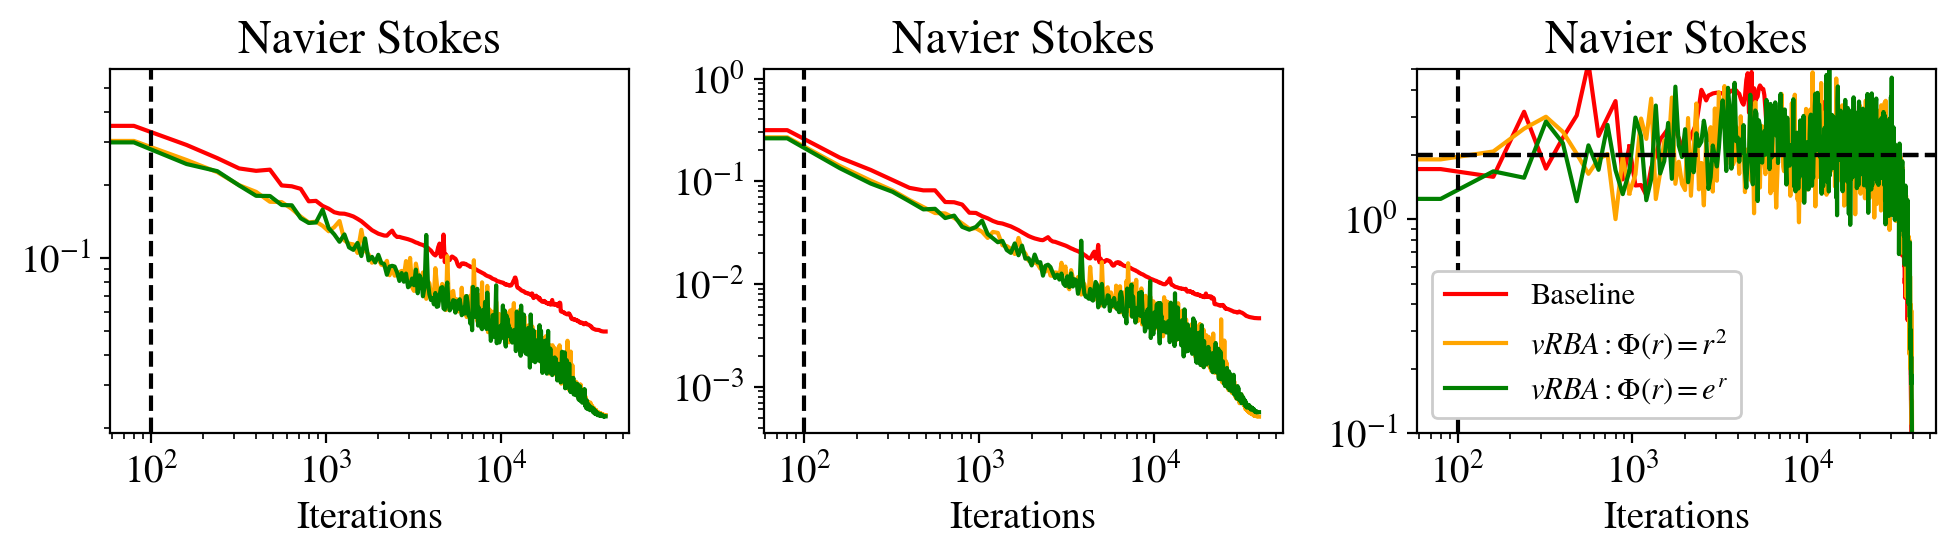

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Note: The variables `legend_ls`, `val_loss_ls`, `Var_ls`, 
# and `KL_ls` are assumed to be defined in your environment.

# Create a figure with one row and three columns, matching the agreed style.
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

# --- USER-ADJUSTABLE PARAMETERS ---
moving_average_window = 1
smoothing_start_iter = 1000  # The iteration number to start smoothing from
batch_size_scaler = 80       # The scaler for the x-axis (e.g., batch size)

# Loop through each method/key to plot its results
for i, key in enumerate(legend_ls):
    key_lower = key.lower()
    if 'vrba' in key_lower:
        color = 'green'
        title_plot=rf'$vRBA:\Phi(r)=e^{{r}}$'
    elif 'rba' in key_lower:
        color = 'orange'
        title_plot=rf'$vRBA:\Phi(r)=r^{{2}}$'
    elif 'uniform' in key_lower:
        color = 'red'
        title_plot=rf'Baseline'
    else:
        color = 'gray'
    label = key
    print(key, val_loss_ls[i][-1])
    # --- Plot 1: Relative L^2 Error (Validation Loss) ---
    x_data_loss = np.arange(len(val_loss_ls[i])) * batch_size_scaler
    axes[0].plot(x_data_loss, val_loss_ls[i], label=title_plot, color=color)

    # --- Plot 2: Square Root of Variance ---
    x_data_var = np.arange(len(Var_ls[i])) * batch_size_scaler
    plot_data_var = np.sqrt(np.abs(Var_ls[i]))
    axes[1].plot(x_data_var, plot_data_var, label=title_plot, color=color)

    # --- Plot 3: SNR with a guaranteed continuous transition ---
    x_data_snr = np.arange(len(KL_ls[i])) * batch_size_scaler
    snr_data = np.array(KL_ls[i]) # Ensure it's a numpy array for manipulation

    # Calculate the array index at which to start smoothing
    smoothing_start_index = smoothing_start_iter // batch_size_scaler

    # 1. Plot the initial, unsmoothed part of the data.
    # The label is attached here so it appears only once in the legend.
    axes[2].plot(x_data_snr[:smoothing_start_index + 1], 
                 snr_data[:smoothing_start_index + 1], 
                 label=title_plot, 
                 color=color)

    # 2. Smooth the later part and force a connection.
    if len(snr_data) > smoothing_start_index:
        # Isolate the data segment that needs to be smoothed
        data_to_smooth = snr_data[smoothing_start_index:]
        x_for_smoothing = x_data_snr[smoothing_start_index:]
        
        # Apply the moving average
        smoothed_data = np.convolve(data_to_smooth, np.ones(moving_average_window)/moving_average_window, mode='same')
        
        # **FIX:** Force the smoothed segment to start at the exact point where
        # the raw data segment ended. This eliminates the vertical jump.
        smoothed_data[0] = snr_data[smoothing_start_index]
        
        # Plot the corrected smoothed part (without a label)
        axes[2].plot(x_for_smoothing, smoothed_data, color=color)
        axes[2].axhline(y=2, color='k', linestyle='--')

# --- Formatting and Annotations (from the style template) ---

# Define titles for each subplot
titles = [
    "Navier Stokes",
    "Navier Stokes",
    "Navier Stokes"
]

# Apply formatting to each subplot
for ax, title in zip(axes, titles):
    ax.set_title(title)
    ax.set_yscale('log')
    ax.set_xlabel(r"Iterations")
    ax.axvline(x=100, color='k', linestyle='--')   
    #ax.axvline(x=200, color='k', linestyle='--')   
axes[2].set_xscale('log')
axes[1].set_xscale('log')
axes[0].set_xscale('log')
axes[2].set_ylim(0.1,5)

# Add legend only to the first plot
axes[2].legend(fontsize=11, facecolor='white',framealpha=1,loc='lower left') #frameon=True)

# Adjust layout to prevent labels from overlapping
plt.tight_layout()

# Save and show the figure
plt.savefig("DN_results_connected.png", dpi=300, bbox_inches='tight')
plt.show()

# Plotting the states

In [9]:
TRUE = np.load("/users/jdtoscan/data/jdtoscan/RBA+Operators/ns_fno/Vanilla/Y_TRUE.npy")
PRED = np.load("/users/jdtoscan/data/jdtoscan/RBA+Operators/ns_fno/Vanilla/Y_PRED.npy")
PRED_rba = np.load("/users/jdtoscan/data/jdtoscan/RBA+Operators/ns_fno/vrba_sample/Y_PRED.npy")


print("w/0 rba : ", np.mean( (TRUE - PRED)**2 ))
print("with rba: ", np.mean( (TRUE - PRED_rba)**2 ))

w/0 rba :  0.0020524345
with rba:  0.00041460805


/tmp/ipykernel_1034786/2015192251.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.9, 1])


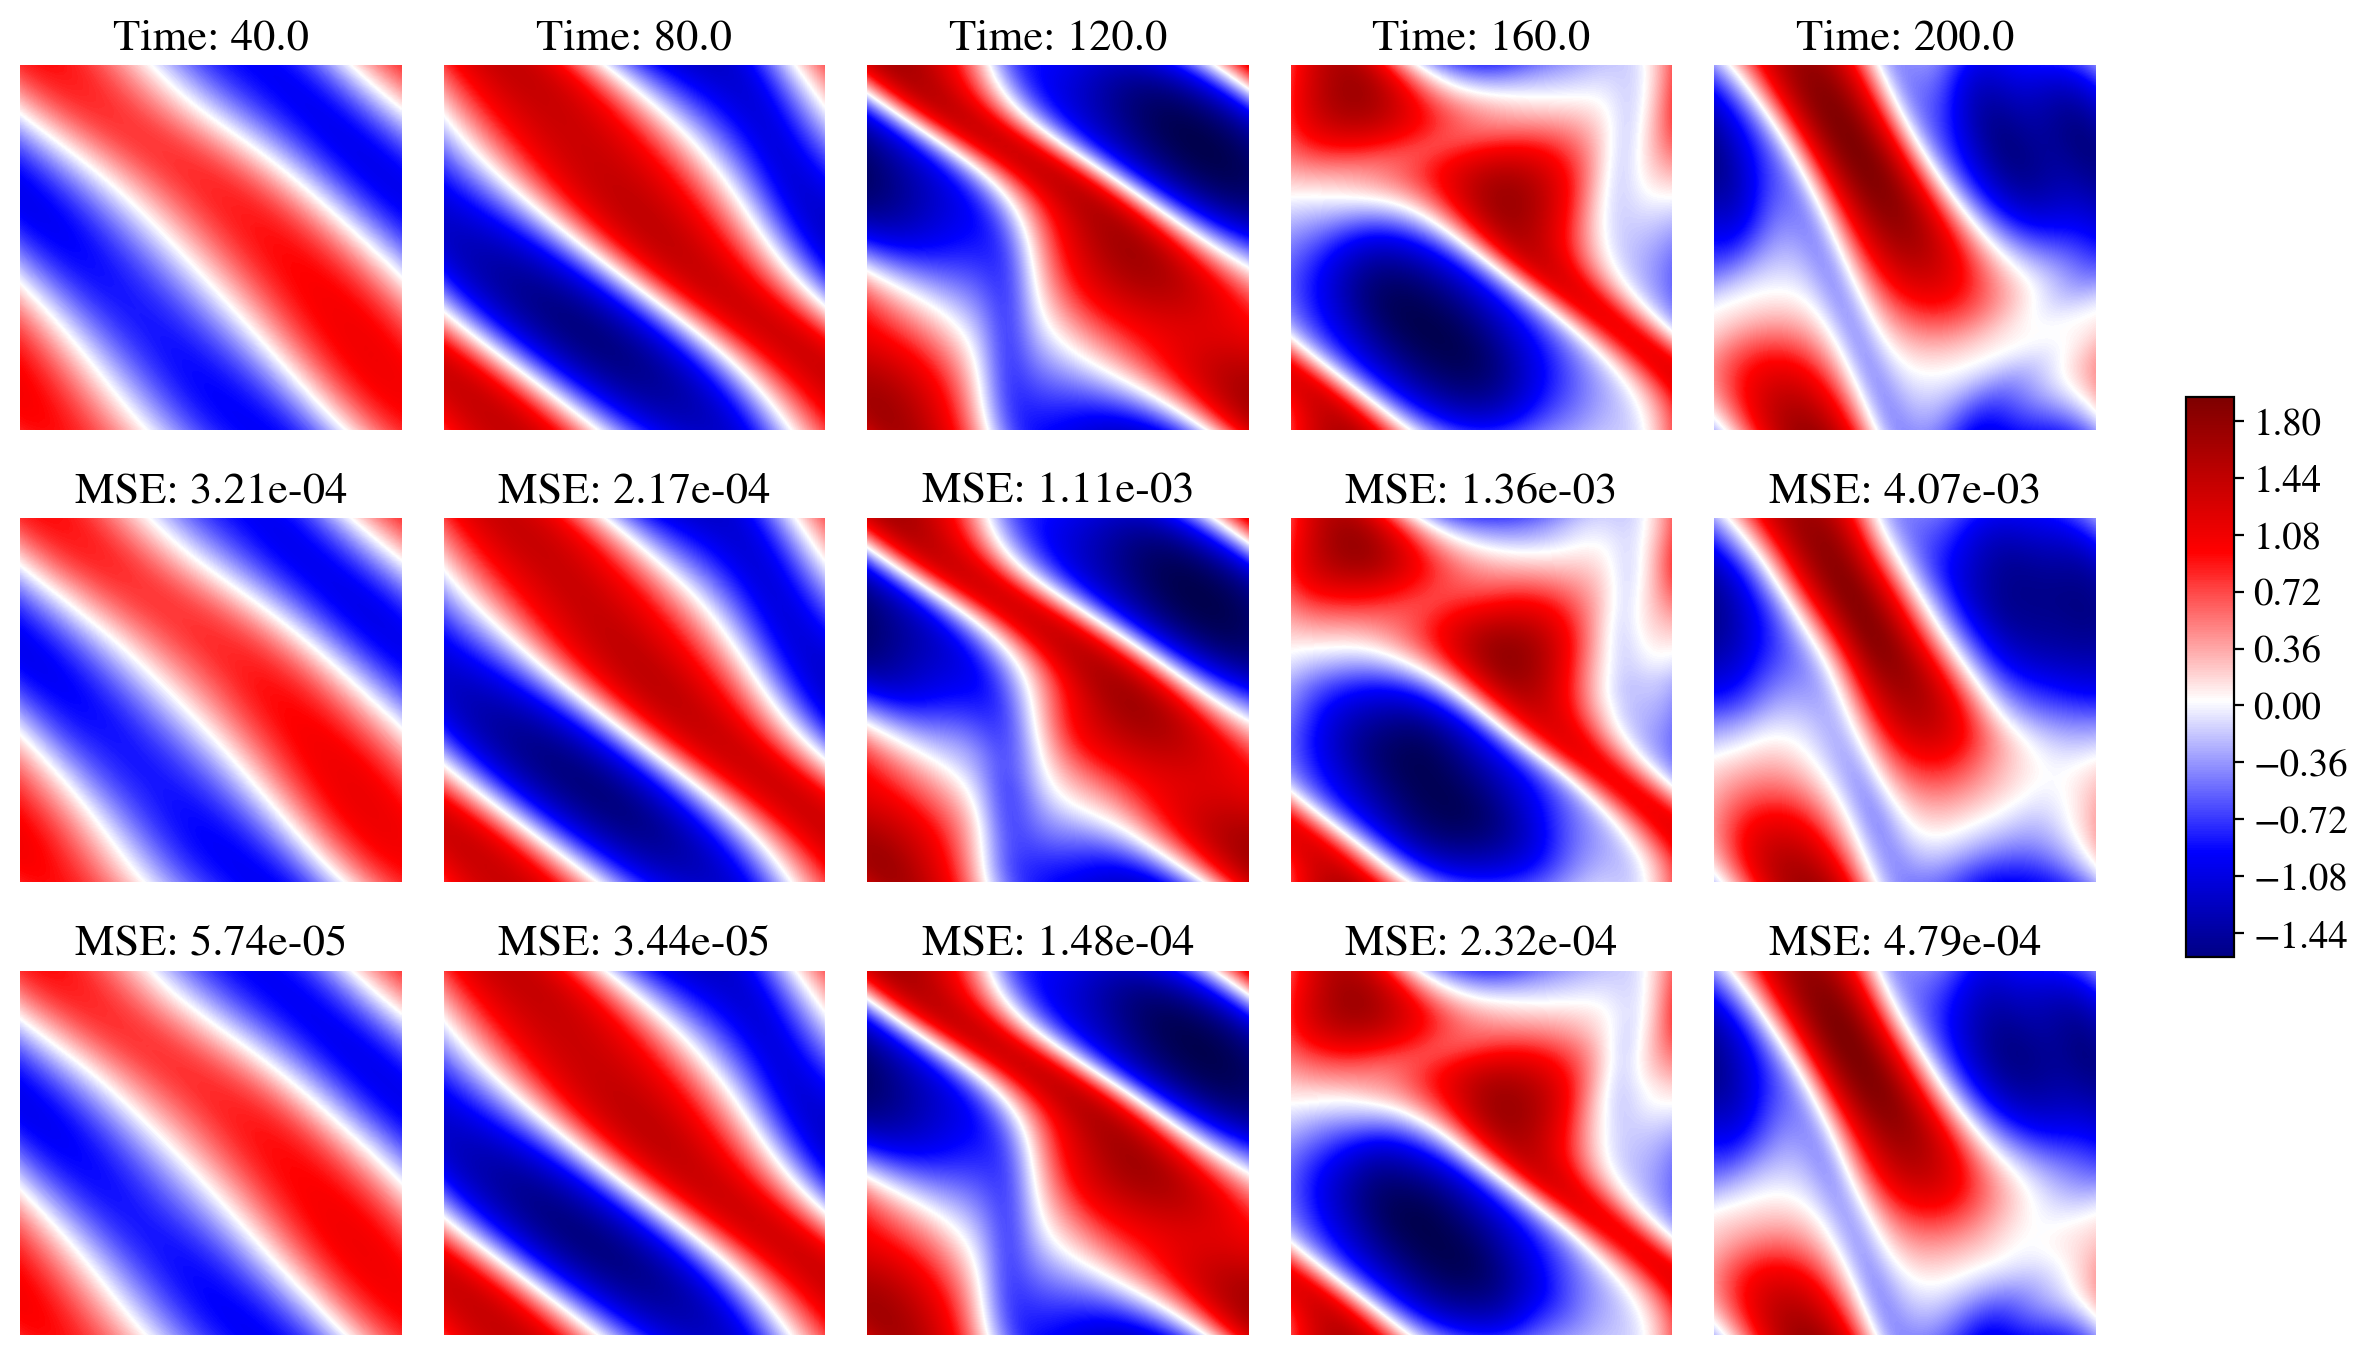

In [10]:
sample_id = 0
skip_t = 10
t_ls = np.linspace(0,200,51)
true = TRUE[sample_id, ::skip_t][1:]
pred1 = PRED[sample_id, ::skip_t][1:]
pred2 = PRED_rba[sample_id, ::skip_t][1:]
time_ls = t_ls[::skip_t][1:]


CMAP = 'seismic'

# Function to calculate MSE
def mse(a, b):
    return np.mean((a - b) ** 2)

# Create the figure and axis
fig, axes = plt.subplots(3, 5, figsize=(12, 7))
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # Colorbar axis

# Find the min and max values for colorbar
vmin = min(true.min(), pred1.min(), pred2.min())
vmax = max(true.max(), pred1.max(), pred2.max())

# Plot the images
for i in range(5):
    # Ground truth row
    im = axes[0, i].contourf(true[i], 300, vmin=vmin, vmax=vmax, cmap=CMAP)
    axes[0, i].set_title(f'Time: {time_ls[i]}', fontsize=16)
    axes[0, i].axis('off')

    # Prediction 1 row
    im = axes[1, i].contourf(pred1[i], 300, vmin=vmin, vmax=vmax, cmap=CMAP)
    mse_val1 = mse(true[i], pred1[i])
    axes[1, i].set_title(f'MSE: {mse_val1:.2e}', fontsize=16)
    axes[1, i].axis('off')

    # Prediction 2 row
    im = axes[2, i].contourf(pred2[i], 300, vmin=vmin, vmax=vmax, cmap=CMAP)
    mse_val2 = mse(true[i], pred2[i])
    axes[2, i].set_title(f'MSE: {mse_val2:.2e}', fontsize=16)
    axes[2, i].axis('off')

# Add row labels
# fig.text(-0.008, 0.81, 'Ground truth', va='center', ha='center', rotation='vertical', fontsize=18)
# fig.text(-0.008, 0.49, r'$FNO$', va='center', ha='center', rotation='vertical', fontsize=18)
# fig.text(-0.008, 0.16, r'$RBA_s$', va='center', ha='center', rotation='vertical', fontsize=18)

# Adjust layout
fig.tight_layout(rect=[0, 0, 0.9, 1])
fig.colorbar(im, cax=cbar_ax)
plt.savefig('all_Frames.png')
plt.show()

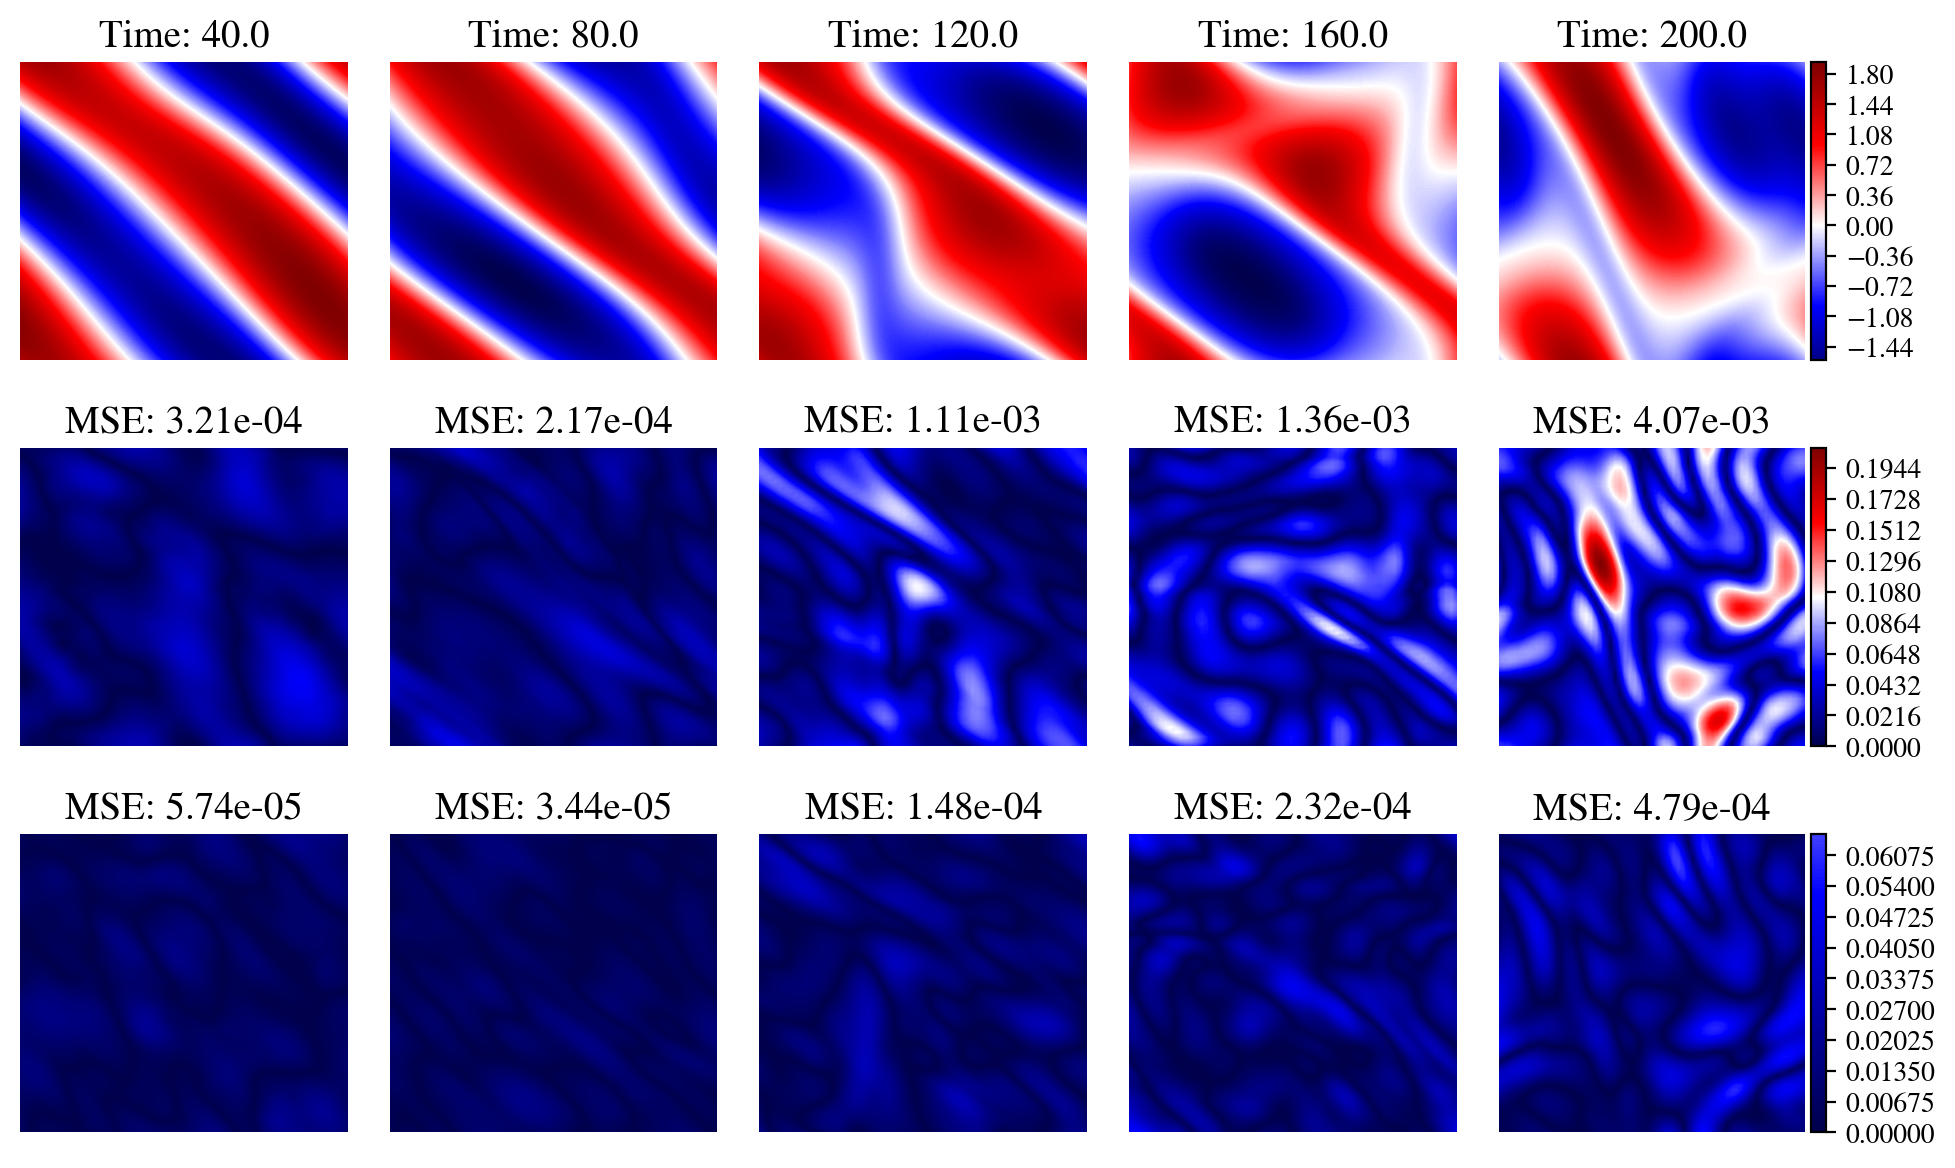

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

sample_id = 0
skip_t = 10
t_ls = np.linspace(0, 200, 51)
true = TRUE[sample_id, ::skip_t][1:]
pred1 = PRED[sample_id, ::skip_t][1:]
pred2 = PRED_rba[sample_id, ::skip_t][1:]
time_ls = t_ls[::skip_t][1:]

CMAP = 'seismic'
fontsize=14
# MSE function
def mae(a, b):
    return np.mean(np.abs(a - b)**2)

# Global color scale from ground truth
vmin = np.min(np.abs(pred1-true))
vmax = np.max(np.abs(pred1-true))
norm = Normalize(vmin=vmin, vmax=vmax)

fig, axes = plt.subplots(3, 5, figsize=(10, 6), constrained_layout=False)

for i in range(5):
    # --- Ground truth ---
    im0 = axes[0, i].contourf(true[i], 300,vmin=-np.max(np.abs(true[i])),vmax=np.max(np.abs(true[i])), cmap=CMAP)
    axes[0, i].set_title(f'Time: {time_ls[i]:.1f}', fontsize=fontsize)
    axes[0, i].axis('off')

    # --- FNO prediction ---
    im1 = axes[1, i].contourf(np.abs(pred1[i]-true[i]), 300,vmin=vmin,vmax=vmax, cmap=CMAP)
    axes[1, i].set_title(f'MSE: {mae(true[i], pred1[i]):.2e}', fontsize=fontsize)
    axes[1, i].axis('off')

    # --- RBA_s prediction ---
    im2 = axes[2, i].contourf(np.abs(pred2[i]-true[i]), 300, vmin=vmin,vmax=vmax, cmap=CMAP)
    axes[2, i].set_title(f'MSE: {mae(true[i], pred2[i]):.2e}', fontsize=fontsize)
    axes[2, i].axis('off')

# Add colorbars to the last column only
for row, im in enumerate([im0, im1, im2]):
    cbar = plt.colorbar(im, ax=axes[row, 4], fraction=0.046, pad=0.02)
    cbar.ax.tick_params(labelsize=10)

plt.tight_layout()
plt.savefig('all_Frames_errors.png',dpi=300)
plt.show()


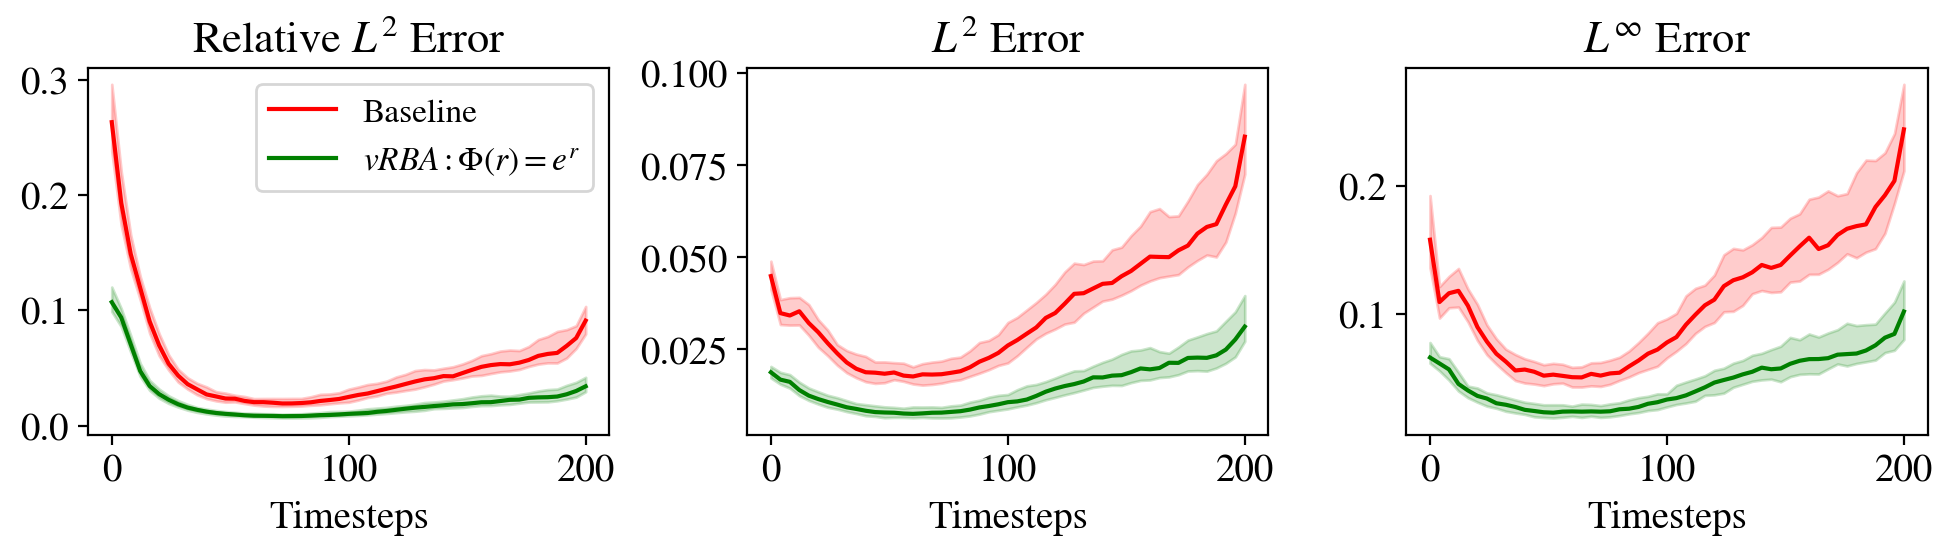

In [12]:
from scipy.linalg import norm
import numpy as np
import matplotlib.pyplot as plt

# --- Your Original Code for Data Prep & Relative L2 Error ---
# (Assuming TRUE, PRED, PRED_rba are loaded)
TRUE_flat = TRUE.reshape(TRUE.shape[0], TRUE.shape[1], -1)
PRED_flat = PRED.reshape(PRED.shape[0], PRED.shape[1], -1)
PRED_rba_flat = PRED_rba.reshape(PRED_rba.shape[0], PRED_rba.shape[1], -1)

# Compute relative L2 error for each sample and time step (your original loops)
err = np.array([
    [norm(PRED_flat[i, j] - TRUE_flat[i, j]) / norm(TRUE_flat[i, j]) if norm(TRUE_flat[i, j]) != 0 else 0
     for j in range(TRUE.shape[1])]
    for i in range(TRUE.shape[0])
])

err_rba = np.array([
    [norm(PRED_rba_flat[i, j] - TRUE_flat[i, j]) / norm(TRUE_flat[i, j]) if norm(TRUE_flat[i, j]) != 0 else 0
     for j in range(TRUE.shape[1])]
    for i in range(TRUE.shape[0])
])

# Compute percentiles for relative L2 error (your original calculations)
percentile_25_err = np.percentile(err, 25, axis=0)
percentile_50_err = np.percentile(err, 50, axis=0)
percentile_75_err = np.percentile(err, 75, axis=0)

percentile_25_err_rba = np.percentile(err_rba, 25, axis=0)
percentile_50_err_rba = np.percentile(err_rba, 50, axis=0)
percentile_75_err_rba = np.percentile(err_rba, 75, axis=0)

# Time steps
timesteps = np.linspace(0, 200, TRUE.shape[1])

# --- ADDED: Calculate L2 and L-infinity Error Norms ---
# For efficiency, these new calculations are vectorized. 🚀

# Absolute L2 error norm: ||y_pred - y_true||_2
l2_err_abs =np.sqrt(np.mean((PRED_flat - TRUE_flat)**2,axis=2))
l2_err_abs_rba =np.sqrt(np.mean((PRED_rba_flat - TRUE_flat)**2,axis=2) )
# Absolute L-infinity error norm: ||y_pred - y_true||_inf
linf_err_abs = np.max(np.abs(PRED_flat - TRUE_flat), axis=2)
linf_err_abs_rba = np.max(np.abs(PRED_rba_flat - TRUE_flat), axis=2)


# --- ADDED: Compute Statistics for New Metrics ---
p50_l2_abs = np.percentile(l2_err_abs, 50, axis=0)
p25_l2_abs = np.percentile(l2_err_abs, 25, axis=0)
p75_l2_abs = np.percentile(l2_err_abs, 75, axis=0)
p50_l2_abs_rba = np.percentile(l2_err_abs_rba, 50, axis=0)
p25_l2_abs_rba = np.percentile(l2_err_abs_rba, 25, axis=0)
p75_l2_abs_rba = np.percentile(l2_err_abs_rba, 75, axis=0)

p50_linf_abs = np.percentile(linf_err_abs, 50, axis=0)
p25_linf_abs = np.percentile(linf_err_abs, 25, axis=0)
p75_linf_abs = np.percentile(linf_err_abs, 75, axis=0)
p50_linf_abs_rba = np.percentile(linf_err_abs_rba, 50, axis=0)
p25_linf_abs_rba = np.percentile(linf_err_abs_rba, 25, axis=0)
p75_linf_abs_rba = np.percentile(linf_err_abs_rba, 75, axis=0)


# --- MODIFIED: Plotting in 3 Columns ---
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=False)

# Plot 1: Relative L2 Error (using your original variables)
axs[0].plot(timesteps, percentile_50_err, color='red', label='Baseline')
axs[0].fill_between(timesteps, percentile_25_err, percentile_75_err, color='red', alpha=0.2)
axs[0].plot(timesteps, percentile_50_err_rba, color='green', label=rf'$vRBA:\Phi(r)=e^r$')
axs[0].fill_between(timesteps, percentile_25_err_rba, percentile_75_err_rba, color='green', alpha=0.2)
axs[0].set_title('Relative $L^2$ Error', fontsize=16)
#axs[0].set_yscale('log')

# Plot 2: Absolute L2 Error Norm
axs[1].plot(timesteps, p50_l2_abs, color='red', label='Baseline')
axs[1].fill_between(timesteps, p25_l2_abs, p75_l2_abs, color='red', alpha=0.2)
axs[1].plot(timesteps, p50_l2_abs_rba, color='green', label=rf'$vRBA:\Phi(r)=e^r$')
axs[1].fill_between(timesteps, p25_l2_abs_rba, p75_l2_abs_rba, color='green', alpha=0.2)
axs[1].set_title('$L^2$ Error ', fontsize=16)
#axs[1].set_yscale('log')

# Plot 3: Absolute L-infinity Error Norm
axs[2].plot(timesteps, p50_linf_abs, color='red', label='Baseline')
axs[2].fill_between(timesteps, p25_linf_abs, p75_linf_abs, color='red', alpha=0.2)
axs[2].plot(timesteps, p50_linf_abs_rba, color='green', label=rf'$vRBA:\Phi(r)=e^r$')
axs[2].fill_between(timesteps, p25_linf_abs_rba, p75_linf_abs_rba, color='green', alpha=0.2)
axs[2].set_title('$L^\infty$ Error', fontsize=16)
#axs[2].set_yscale('log')

# Common formatting for all subplots
for i,ax in enumerate(axs):
    ax.set_xlabel('Timesteps', fontsize=14)
    if i==0:
        #ax.set_ylabel('Error Value', fontsize=14)
        ax.legend(fontsize=12)
    #ax.grid(True, which="both", ls="--", alpha=0.6)

plt.tight_layout()
plt.savefig('Error_Metrics_3_Plots.png', dpi=300)
plt.show()